In [1]:
%matplotlib inline
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7313734115192720162
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 7390229300
locality {
  bus_id: 1
}
incarnation: 16263669847916550204
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0"
, name: "/gpu:1"
device_type: "GPU"
memory_limit: 7968243712
locality {
  bus_id: 1
}
incarnation: 8625729302045675469
physical_device_desc: "device: 1, name: GeForce GTX 1080, pci bus id: 0000:07:00.0"
]


In [3]:
%%time
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

CPU times: user 24.1 s, sys: 444 ms, total: 24.5 s
Wall time: 24.5 s


In [4]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [5]:
len(train_img),len(train_label)

(42000, 42000)

## Визуализируем исходные данные

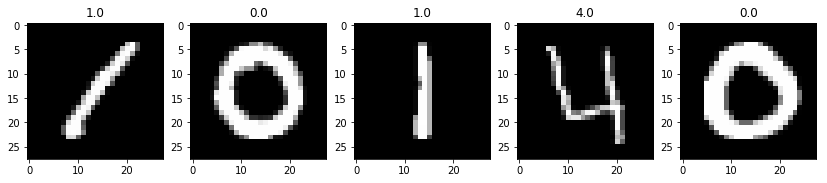

In [6]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [7]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [8]:
test_sobel_x.shape

(28000, 28, 28)

## Вычисляем угол и длину вектора градиента

Делим картинку на 16 частей (4x4) и для каждой части считаем гистограмму градиентов, 
затем объединяем (concat) все вектора в один

In [9]:
BIN=16
NX=4
NY=4
def get_features(imgx,imgy):
    dx=imgx.shape[1]//NX
    dy=imgx.shape[0]//NY
    rez=np.zeros((NY,NX,BIN))
    for ix in range(NX):
        for iy in range(NY):
            x1=dx*ix
            y1=dy*iy
            g,theta=cv2.cartToPolar(imgx[y1:y1+dy,x1:x1+dx], imgy[y1:y1+dy,x1:x1+dx])
            hist, borders=np.histogram(theta,bins=BIN,range=(0., 2. * np.pi),weights=g)
            rez[iy,ix]=hist
    return rez.flatten()


## Вычисляем гистограммы градиентов

In [10]:
%%time
train_hist = np.zeros((len(train_img), NX*NY*BIN))
for i,img in enumerate(train_img):
    train_hist[i] = get_features(train_sobel_x[i],train_sobel_y[i])
test_hist = np.zeros((len(test_img), NX*NY*BIN))
for i,img in enumerate(test_img):
    test_hist[i] = get_features(test_sobel_x[i],test_sobel_y[i])

CPU times: user 1min 5s, sys: 20 ms, total: 1min 5s
Wall time: 1min 5s


## Нормируем вектор гистограммы

In [11]:
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [12]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    np.array(train_label), np.array(train_hist), test_size=0.1, random_state=42)

## Собираем полносвязную сеть для обучения

In [13]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(256, input_dim=x_train.shape[1], activation='relu'))
model.add(keras.layers.Dropout(0.4, noise_shape=None, seed=123))
model.add(keras.layers.Dense(256, input_dim=x_train.shape[1], activation='relu'))
model.add(keras.layers.Dropout(0.4, noise_shape=None, seed=1234))
model.add(keras.layers.Dense(256, input_dim=x_train.shape[1], activation='relu'))
model.add(keras.layers.Dropout(0.4, noise_shape=None, seed=12345))
model.add(keras.layers.Dense(10, activation='softmax'))

from keras import optimizers
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Выводим информацию о модели

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2570      
Total para

## One hot encoding разметки

In [15]:
from keras.utils import np_utils
y_train_labels = np_utils.to_categorical(y_train)

In [16]:
y_train_labels.shape

(37800, 10)

## Запускаем обучение

Переодически проверяем решение на валидационной выборке, для контроля переобучения 

In [17]:
from sklearn.metrics import accuracy_score
for t in range(6):
    model.fit(x_train, y_train_labels, batch_size=64,epochs=10)
    pred_val = model.predict_classes(x_val)
    print('\n#%d Accuracy: %s\n' % (t,accuracy_score(y_val, pred_val)))

Epoch 1/10
37800/37800 [==============================] - 1s - loss: 0.3769 - acc: 0.8841     
Epoch 2/10
37800/37800 [==============================] - 1s - loss: 0.1172 - acc: 0.9649     
Epoch 3/10
37800/37800 [==============================] - 1s - loss: 0.0930 - acc: 0.9725     
Epoch 4/10
37800/37800 [==============================] - 1s - loss: 0.0748 - acc: 0.9777     
Epoch 5/10
37800/37800 [==============================] - 1s - loss: 0.0672 - acc: 0.9801     
Epoch 6/10
37800/37800 [==============================] - 1s - loss: 0.0577 - acc: 0.9828     
Epoch 7/10
37800/37800 [==============================] - 1s - loss: 0.0514 - acc: 0.9847     
Epoch 8/10
37800/37800 [==============================] - 1s - loss: 0.0482 - acc: 0.9853     
Epoch 9/10
37800/37800 [==============================] - 1s - loss: 0.0439 - acc: 0.9873     
Epoch 10/10
3360/4200 [=======================>......] - ETA: 0s
#0 Accuracy: 0.984047619048

Epoch 1/10
37800/37800 [===========================

## Предсказываем класс объекта

In [18]:
pred_val = model.predict_classes(x_val)

3168/4200 [=====================>........] - ETA: 0s

## Оцениваем качество решение на валидационной выборке

In [19]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.99


In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       1.00      0.99      1.00       408
        1.0       1.00      0.99      1.00       471
        2.0       1.00      0.99      0.99       420
        3.0       0.99      0.99      0.99       506
        4.0       0.99      0.98      0.98       397
        5.0       0.99      0.99      0.99       339
        6.0       0.99      1.00      0.99       402
        7.0       0.98      0.99      0.99       438
        8.0       0.98      0.99      0.99       403
        9.0       0.99      0.99      0.99       416

avg / total       0.99      0.99      0.99      4200



In [21]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[405   0   1   0   0   0   1   0   1   0]
 [  0 468   1   0   0   0   0   2   0   0]
 [  0   0 416   0   0   1   1   0   2   0]
 [  0   0   0 501   0   3   0   1   1   0]
 [  0   0   0   0 389   0   2   2   0   4]
 [  0   0   0   2   0 337   0   0   0   0]
 [  0   0   0   0   0   0 400   0   2   0]
 [  0   0   0   0   2   0   0 433   1   2]
 [  1   0   0   0   1   1   0   1 399   0]
 [  0   0   0   1   2   0   0   2   1 410]]


## Предсказания на тестовыйх данных

In [22]:
pred_test = model.predict_classes(test_hist)

25152/28000 [=========================>....] - ETA: 0s

## Визуализируем предсказания

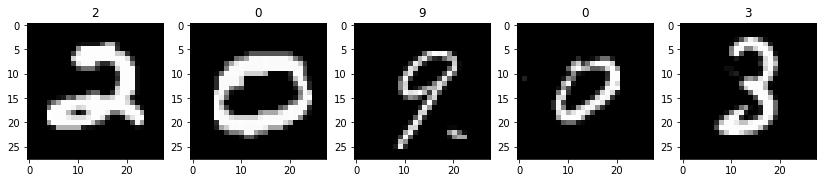

In [23]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [24]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [25]:
# Your submission scored 0.98614